# PS 4Impulse Response Functions for a Monetary Policy Shock
In the previous exercise set you obtained monetary policy shocks for the UK, following the narrative identification strategy by Cloyne and Hürtgen (2016). 
In case that you couldn’t get the shocks, this are also provided in the data file
“monthlyShocks.xlsx” columns F and G.

1. Load the data file “regressionData.xlsx” that we provided to you. This data set contains all the variables necessary for obtaining the IRFs:
- BankRate: rate of the Bank of England.
- Unemp Rate: unemployment rate.
- IoP: industrial production.
- CommodityPriceIndex: commodity price index.
- CPIindex: consumer price index.

2. For industrial production, CPI and commodity price index modify each original variable to be $logx = log(x) ×100$.
3. Run a local projection à la Jordà (2005) using monthly shocks to obtain IRFs for inflation, industrial production and the bank rate from
$$
    y_{t+h} = \alpha_h + \theta_h shock_t + \text{control variables} + \epsilon_{t+h}
$$
In the control variables include four lags of industrial production, CPI, commodity price index and the shock.
(Cloyne and Hürtgen (2016) actually use 48 lags of the shocks in their regression. This is also done in the code provided below.)
4. Plot the IRFs.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load the data

In [2]:
# validate the previous exercise with the original shocks
data_orig = pd.read_excel('data/monthlyShocks.xlsx')
shocks_orig = data_orig['Assigned to months']
shocks_orig.index = data_orig['Date']
shocks_orig = shocks_orig.dropna()


In [3]:
# read in the additional data for the regression
regression_data_untransformed = pd.read_excel('data/regressionData.xlsx', sheet_name='Monthly UK')
# select the columns of interest
select_columns = ['Date', 'IoP', 'RPIX12m', 'CommodityPriceIndex (log)', 'BankRate']
regression_data_untransformed = regression_data_untransformed[select_columns]
# set the date as index and drop the date column
regression_data_untransformed.index = regression_data_untransformed['Date']
regression_data_untransformed = regression_data_untransformed.drop('Date', axis=1)
regression_data_untransformed.head()

,IoP,RPIX12m,CommodityPriceIndex (log),BankRate
Date,,,,
1975-01-31,71.7,19.9,2.776583,11.00
1975-02-28,71.1,19.9,2.723822,10.50
1975-03-31,69.7,21.2,2.671283,10.00
1975-04-30,68.5,21.7,2.671131,9.75
1975-05-31,67.6,25.0,2.664358,10.00


In [4]:
# you will see below, that I create lags of variables in a for loop.
# For to create the names of the variables, I use the f-string method, but you could also use the string concatenation method.
regression_data_temp = regression_data_untransformed.copy()
list_names = []
n_lags = 4
for i in range(1, n_lags+1): # remember that the range function goes up to the second argument, but does not include it
    # regression_data_temp[f'IoP{i}'] = regression_data_temp['shocks'].shift(i)
    regression_data_temp['IoP_lag'+str(i)] = regression_data_temp['IoP'].shift(i)
    list_names.append(f'IoP_lag{i}')

# those are the new columns created in the loop
print(list_names)

['IoP_lag1', 'IoP_lag2', 'IoP_lag3', 'IoP_lag4']


In [5]:
# below I will also use list comprehension to create new lists of variables
# this is a more elegant way of creating the lists

# create a list of the names of the variables
list_names = [f'IoP_lag{i}' for i in range(1, n_lags+1)] 
# the list comprehensions does a for loop in one line and creates a list of the results

# do the same with a for loop
list_names2 = []
for i in range(1, n_lags+1):
    list_names2.append(f'IoP_lag{i}')

print(list_names)
print(list_names2)

['IoP_lag1', 'IoP_lag2', 'IoP_lag3', 'IoP_lag4']
['IoP_lag1', 'IoP_lag2', 'IoP_lag3', 'IoP_lag4']


In [6]:
# to create the formulas for the regression, we need to create a string with the names of the variables.
# we can use the join method of the string object to concatenate the names of the variables with a plus sign
joined_names = " + ".join(list_names)
print(joined_names)
formula = f'IoP ~ {" + ".join(list_names)}' 
# the same with string concatenation
formula = f'IoP ~ ' + ' + '.join(list_names) 
print(formula)

IoP_lag1 + IoP_lag2 + IoP_lag3 + IoP_lag4
IoP ~ IoP_lag1 + IoP_lag2 + IoP_lag3 + IoP_lag4


# 2. Transform the variables

In [7]:
regression_data = regression_data_untransformed.copy()

# rename columns
regression_data = regression_data.rename(columns={
    'CommodityPriceIndex (log)': 'CommodityPriceIndex_log',
    'RPIX12m': 'CPIindex',})

# apply 100 * log transformation to the variables
regression_data[['IoP_log', 'CPIindex_log']] = regression_data[['IoP', 'CPIindex']].apply(np.log)
regression_data[['IoP_log', 'CommodityPriceIndex_log']] = regression_data[['IoP_log', 'CommodityPriceIndex_log']] * 100

vars_to_diff = ['CPIindex_log', 'IoP_log', 'CommodityPriceIndex_log', 'BankRate']
for var in vars_to_diff:
    regression_data[f'{var}_diff'] = regression_data[var].diff()
# Same as
# regression_data['CPIindex_log_diff'] = regression_data['CPIindex_log'].diff()
# regression_data['IoP_log_diff'] = regression_data['IoP_log'].diff()
# ...

# append the shock series
regression_data['shocks'] = shocks_orig

# create lags for each variable
vars_to_lag = ['CPIindex_log_diff', 'BankRate_diff', 'IoP_log_diff', 'CommodityPriceIndex_log_diff']
n_lags = 4
for var in vars_to_lag:
    for i in range(1, n_lags+1):
        regression_data[f'{var}_lag{i}'] = regression_data[var].shift(i)

n_lags_shocks = 48
for i in range(1, n_lags_shocks+1):
    regression_data[f'shocks_lag{i}'] = regression_data['shocks'].shift(i)

# replace NaNs with zeros
regression_data = regression_data.fillna(0)

regression_data.head()

,IoP,CPIindex,CommodityPriceIndex_log,BankRate,IoP_log,CPIindex_log,CPIindex_log_diff,IoP_log_diff,CommodityPriceIndex_log_diff,BankRate_diff,...,shocks_lag39,shocks_lag40,shocks_lag41,shocks_lag42,shocks_lag43,shocks_lag44,shocks_lag45,shocks_lag46,shocks_lag47,shocks_lag48
Date,,,,,,,,,,,,,,,,,,,,,
1975-01-31,71.7,19.9,277.658251,11.00,427.249075,2.990720,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975-02-28,71.1,19.9,272.382171,10.50,426.408734,2.990720,0.000000,-0.840341,-5.276079,-0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975-03-31,69.7,21.2,267.128298,10.00,424.420032,3.054001,0.063281,-1.988702,-5.253873,-0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975-04-30,68.5,21.7,267.113108,9.75,422.683375,3.077312,0.023311,-1.736657,-0.015190,-0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975-05-31,67.6,25.0,266.435802,10.00,421.360798,3.218876,0.141564,-1.322576,-0.677306,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Run the local projection

In [8]:
# specify max horizon of LP
horizon = 48
# initialize thetas and standard_errors
vars_of_interest = ['CPIindex_log_diff', 'IoP_log_diff']
thetas = {var: np.empty(horizon) for var in vars_of_interest}
# same as:
# thetas = {'CPIindex_log_diff': np.empty(horizon), 'IoP_log_diff': np.empty(horizon)}
standard_errors = {var: np.empty(horizon) for var in vars_of_interest}
# same as:
# standard_errors = {'CPIindex_log_diff': np.empty(horizon), 'IoP_log_diff': np.empty(horizon)}

# specify the regression formulas
n_lags = 4
controls = ['CPIindex_log_diff', 'IoP_log_diff', 'CommodityPriceIndex_log_diff']
controls_lags = [f'{var}_lag{i}' for var in controls for i in range(1, n_lags+1)] # and contamporaneous values of controls
# same as:
# controls_lags = []
# for var in controls:
#     for i in range(1, n_lags+1):
#         controls_lags.append(f'{var}_lag{i}')
vars_shock_lags = [f'shocks_lag{i}' for i in range(1, n_lags_shocks+1)]
# same as:
# vars_shock_lags = []
# for i in range(1, n_lags_shocks+1):
#     vars_shock_lags.append(f'shocks_lag{i}')

formula_IoP = "IoP_diff_lead ~ shocks + " + " + ".join(vars_shock_lags + controls_lags)
formula_CPI = "CPIindex_log_diff_lead ~ shocks + " + " + ".join(vars_shock_lags  + controls_lags)

In [9]:
# run LP for all horizons and different dependent variables
for h in range(0,horizon):
    data_h = regression_data.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['IoP_diff_lead'] = data_h['IoP_log'].shift(-h) - data_h['IoP_log']
    data_h['CPIindex_log_diff_lead'] = data_h['CPIindex_log'].shift(-h) - data_h['CPIindex_log']
    data_h = data_h.iloc[horizon:, :] # start at the end of the forecast horizon

    # Model for Industrial Production
    model_IoP = sm.formula.ols(formula=formula_IoP, data=data_h)
    results_IoP = model_IoP.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['IoP_log_diff'][h] = results_IoP.params['shocks']
    standard_errors['IoP_log_diff'][h] = results_IoP.bse['shocks']

    # Model for Inflation
    model_CPI = sm.formula.ols(formula=formula_CPI, data=data_h)
    results_CPI = model_CPI.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['CPIindex_log_diff'][h] = results_CPI.params['shocks']
    standard_errors['CPIindex_log_diff'][h] = results_CPI.bse['shocks']


# 4. Plot IRFs

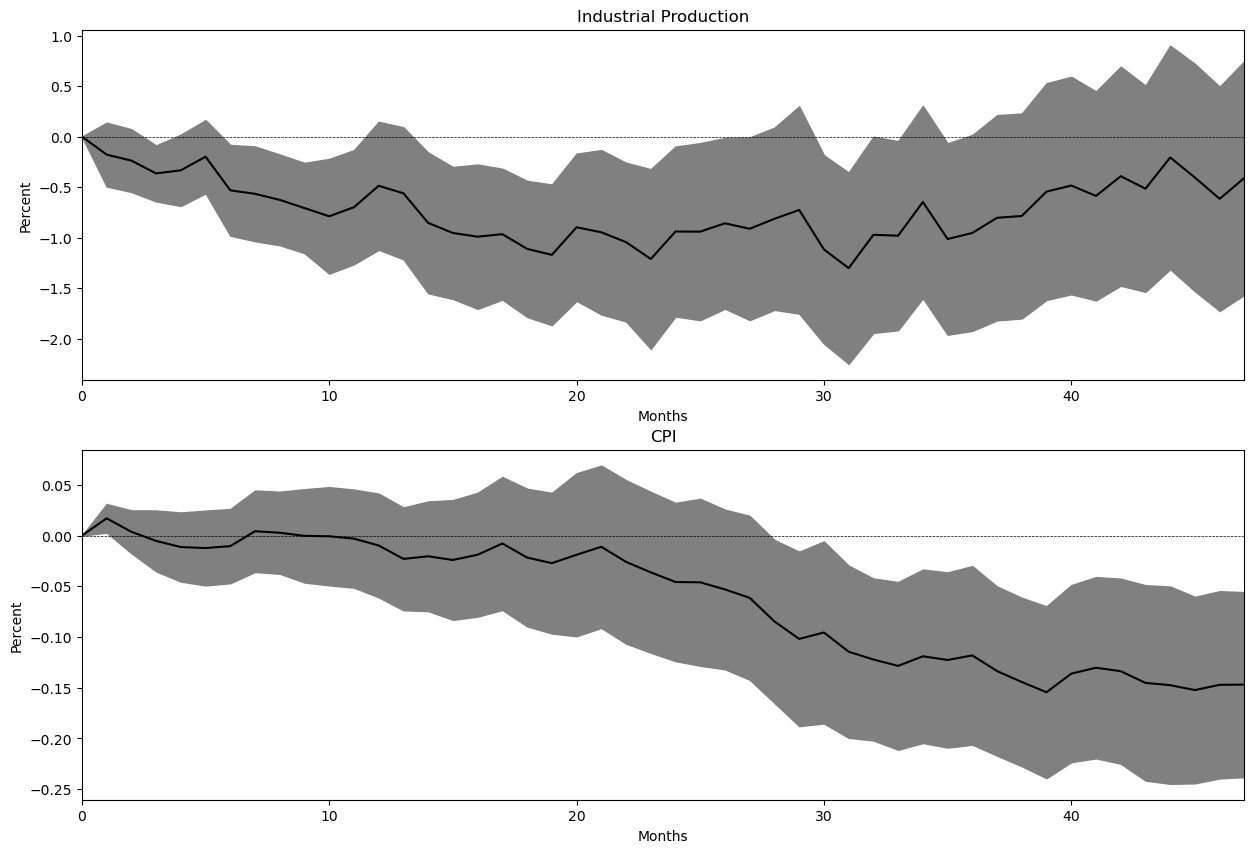

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

var = 'IoP_log_diff'
axs[0].plot(np.arange(len(thetas[var])), thetas[var], color='black')
axs[0].fill_between(np.arange(horizon), thetas[var] - 1.645 *  standard_errors[var], thetas[var] + 1.645 *  standard_errors[var], color='grey')
axs[0].set_title('Industrial Production')

var = 'CPIindex_log_diff'
axs[1].plot(np.arange(len(thetas[var])), thetas[var], color='black')
axs[1].fill_between(np.arange(horizon), thetas[var] - 1.645 *  standard_errors[var], thetas[var] + 1.645 *  standard_errors[var], color='grey')
axs[1].set_title('CPI')

# assign labels and limits for all axes
for ax in axs.flat:
    ax.set_xlabel('Months')
    ax.set_ylabel('Percent')
    ax.set_xlim(0, horizon-1)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.show()

Repeat the local porjection using differnt number of lags:

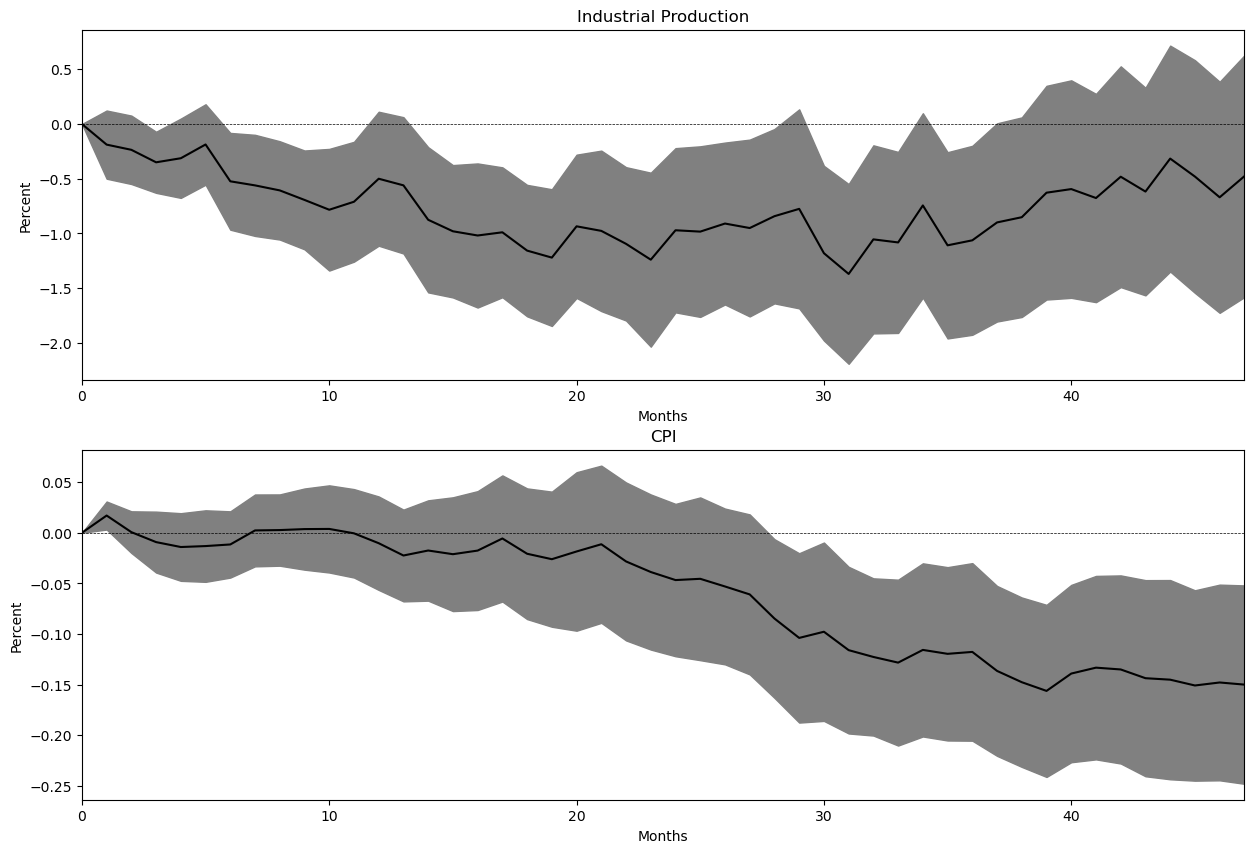

In [11]:
# specify max horizon of LP
horizon = 48
# initialize thetas and standard_errors
vars_of_interest = ['CPIindex_log_diff', 'IoP_log_diff']
thetas = {var: np.empty(horizon) for var in vars_of_interest}
standard_errors = {var: np.empty(horizon) for var in vars_of_interest}

# specify the regression formulas
n_lags = 4
n_lags_shocks = 48
controls = ['CPIindex_log_diff', 'IoP_log_diff'] #, 'CommodityPriceIndex_log_diff']
controls_lags = [f'{var}_lag{i}' for var in controls for i in range(1, n_lags+1)] # and contamporaneous values of controls
# same as:
# controls_lags = []
# for var in controls:
#     for i in range(1, n_lags+1):
#         controls_lags.append(f'{var}_lag{i}')
vars_shock_lags = [f'shocks_lag{i}' for i in range(1, n_lags_shocks+1)]

formula_IoP = "IoP_diff_lead ~ shocks + " + " + ".join(vars_shock_lags + controls_lags)
formula_CPI = "CPIindex_log_diff_lead ~ shocks + " + " + ".join(vars_shock_lags  + controls_lags)

# LP ---------------
# run LP for all horizons and different dependent variables
for h in range(0,horizon):
    data_h = regression_data.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['IoP_diff_lead'] = data_h['IoP_log'].shift(-h) - data_h['IoP_log']
    data_h['CPIindex_log_diff_lead'] = data_h['CPIindex_log'].shift(-h) - data_h['CPIindex_log']
    data_h = data_h.iloc[horizon:, :] # start at the end of the forecast horizon

    # Model for Industrial Production
    model_IoP = sm.formula.ols(formula=formula_IoP, data=data_h)
    results_IoP = model_IoP.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['IoP_log_diff'][h] = results_IoP.params['shocks']
    standard_errors['IoP_log_diff'][h] = results_IoP.bse['shocks']

    # Model for Inflation
    model_CPI = sm.formula.ols(formula=formula_CPI, data=data_h)
    results_CPI = model_CPI.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['CPIindex_log_diff'][h] = results_CPI.params['shocks']
    standard_errors['CPIindex_log_diff'][h] = results_CPI.bse['shocks']

# Plots ---------

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

var = 'IoP_log_diff'
axs[0].plot(np.arange(len(thetas[var])), thetas[var], color='black')
axs[0].fill_between(np.arange(horizon), thetas[var] - 1.645 *  standard_errors[var], thetas[var] + 1.645 *  standard_errors[var], color='grey')
axs[0].set_title('Industrial Production')

var = 'CPIindex_log_diff'
axs[1].plot(np.arange(len(thetas[var])), thetas[var], color='black')
axs[1].fill_between(np.arange(horizon), thetas[var] - 1.645 *  standard_errors[var], thetas[var] + 1.645 *  standard_errors[var], color='grey')
axs[1].set_title('CPI')

# assign labels and limits for all axes
for ax in axs.flat:
    ax.set_xlabel('Months')
    ax.set_ylabel('Percent')
    ax.set_xlim(0, horizon-1)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.show()

# Local Projection-IV

In [12]:
# use the target rate as X and the shocks as instruments
n_lags = 4
n_lags_shocks = 48
controls = ['CPIindex_log_diff', 'IoP_log_diff', 'CommodityPriceIndex_log_diff']
controls_lags = [f'{var}_lag{i}' for var in controls for i in range(1, n_lags+1)]
shock_lags = [f'shocks_lag{i}' for i in range(1, n_lags_shocks+1)]
stage1_formula = "BankRate_diff ~ shocks + " + " + ".join(shock_lags + controls_lags)
stage1_formula

'BankRate_diff ~ shocks + shocks_lag1 + shocks_lag2 + shocks_lag3 + shocks_lag4 + shocks_lag5 + shocks_lag6 + shocks_lag7 + shocks_lag8 + shocks_lag9 + shocks_lag10 + shocks_lag11 + shocks_lag12 + shocks_lag13 + shocks_lag14 + shocks_lag15 + shocks_lag16 + shocks_lag17 + shocks_lag18 + shocks_lag19 + shocks_lag20 + shocks_lag21 + shocks_lag22 + shocks_lag23 + shocks_lag24 + shocks_lag25 + shocks_lag26 + shocks_lag27 + shocks_lag28 + shocks_lag29 + shocks_lag30 + shocks_lag31 + shocks_lag32 + shocks_lag33 + shocks_lag34 + shocks_lag35 + shocks_lag36 + shocks_lag37 + shocks_lag38 + shocks_lag39 + shocks_lag40 + shocks_lag41 + shocks_lag42 + shocks_lag43 + shocks_lag44 + shocks_lag45 + shocks_lag46 + shocks_lag47 + shocks_lag48 + CPIindex_log_diff_lag1 + CPIindex_log_diff_lag2 + CPIindex_log_diff_lag3 + CPIindex_log_diff_lag4 + IoP_log_diff_lag1 + IoP_log_diff_lag2 + IoP_log_diff_lag3 + IoP_log_diff_lag4 + CommodityPriceIndex_log_diff_lag1 + CommodityPriceIndex_log_diff_lag2 + CommodityPr

In [13]:
data_stage1 = regression_data.copy()
model_stage1 = sm.formula.ols(formula=stage1_formula, data=data_stage1)
results_stage1 = model_stage1.fit(cov_type='HAC', cov_kwds={'maxlags':24})
# print(results_stage1.summary())

print("Instrument parameter: ", results_stage1.params['shocks'])
print("Instrument p-value: ", results_stage1.pvalues['shocks'])

# get predicted bank rate
coeffs = results_stage1.params
regression_data['BankRate_hat'] = coeffs['Intercept'] + coeffs['shocks'] * regression_data['shocks']


Instrument parameter:  0.9818572418455789
Instrument p-value:  2.1214545351752727e-34


In [14]:
# Stage 2

# initialize thetas and standard_errors
vars_of_interest = ['CPIindex_log_diff', 'IoP_log_diff']
thetas_IV = {var: np.empty(horizon) for var in vars_of_interest}
standard_errors_IV = {var: np.empty(horizon) for var in vars_of_interest}

formula_IoP_IV = "IoP_diff_lead ~ BankRate_hat + " + " + ".join(shock_lags + controls_lags)
formula_CPI_IV = "CPIindex_log_diff_lead ~ BankRate_hat + " + " + ".join(shock_lags + controls_lags)

In [15]:
# run LP for all horizons and different dependent variables
for h in range(0,horizon):
    data_h = regression_data.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['IoP_diff_lead'] = data_h['IoP_log'].shift(-h) - data_h['IoP_log']
    data_h['CPIindex_log_diff_lead'] = data_h['CPIindex_log'].shift(-h) - data_h['CPIindex_log']
    data_h = data_h.iloc[horizon:, :] # start at the end of the forecast horizon

    # Model for Industrial Production
    model_IoP_IV = sm.formula.ols(formula=formula_IoP_IV, data=data_h)
    results_IoP_IV = model_IoP_IV.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas_IV['IoP_log_diff'][h] = results_IoP_IV.params['BankRate_hat']
    standard_errors_IV['IoP_log_diff'][h] = results_IoP_IV.bse['BankRate_hat']

    # Model for Inflation
    model_CPI_IV = sm.formula.ols(formula=formula_CPI_IV, data=data_h)
    results_CPI_IV = model_CPI_IV.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas_IV['CPIindex_log_diff'][h] = results_CPI_IV.params['BankRate_hat']
    standard_errors_IV['CPIindex_log_diff'][h] = results_CPI_IV.bse['BankRate_hat']


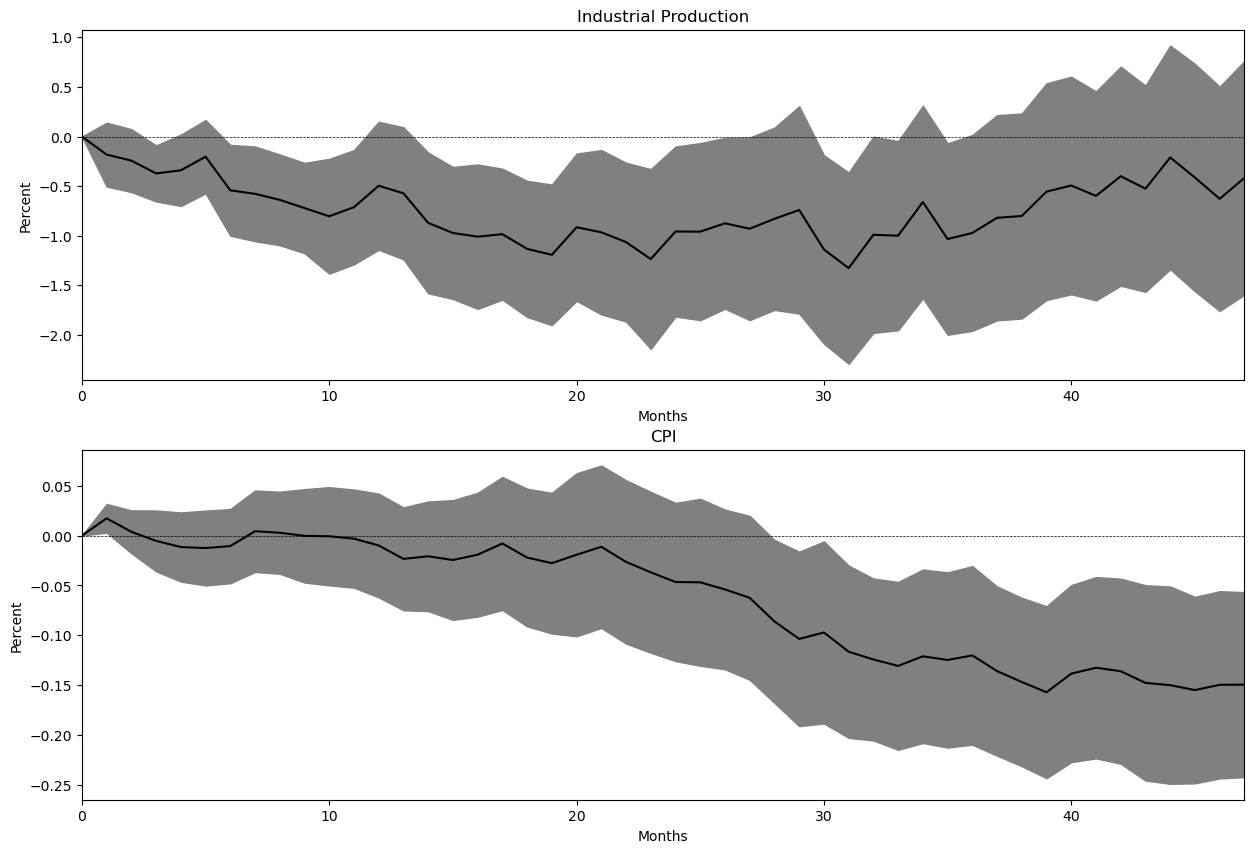

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

var = 'IoP_log_diff'
axs[0].plot(np.arange(len(thetas_IV[var])), thetas_IV[var], color='black')
axs[0].fill_between(np.arange(horizon), thetas_IV[var] - 1.645 *  standard_errors_IV[var], thetas_IV[var] + 1.645 *  standard_errors_IV[var], color='grey')
axs[0].set_title('Industrial Production')

var = 'CPIindex_log_diff'
axs[1].plot(np.arange(len(thetas_IV[var])), thetas_IV[var], color='black')
axs[1].fill_between(np.arange(horizon), thetas_IV[var] - 1.645 *  standard_errors_IV[var], thetas_IV[var] + 1.645 *  standard_errors_IV[var], color='grey')
axs[1].set_title('CPI')

# assign labels and limits for all axes
for ax in axs.flat:
    ax.set_xlabel('Months')
    ax.set_ylabel('Percent')
    ax.set_xlim(0, horizon-1)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.show()